In [1]:
import numpy as np # scientific computing 
import scipy.io
from scipy.stats import stats 
import pandas as pd # data manipulation 
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline 
import time

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Look at the features for the 1000 segments
file = pd.read_excel('SherlockData/Sherlock_Segments_1000_NN_2017.xlsx')
type(file) # Dataframe

pandas.core.frame.DataFrame

In [3]:
file.columns

Index(['Segment Number', 'Start Time (s) ', 'End Time (s) ',
       'Start Time (TRs, 1.5s)', 'End Time (TRs, 1.5s)', 'Scene Segments',
       'Scene Details - A Level ', 'Space-In/Outdoor', 'Name - All',
       'Name - Focus', 'Name - Speaking', 'Location', 'Camera Angle',
       'Music Presence ', 'Words on Screen ', 'Arousal - Rater 1',
       'Valence - Rater 1', 'Arousal - Rater 2', 'Valence - Rater 2',
       'Arousal - Rater 3', 'Valence - Rater 3', 'Arousal - Rater 4',
       'Valence - Rater 4'],
      dtype='object')

In [4]:
print(file.shape) # 1000 segments, 23 variables (1000, 23)
file = file.replace(np.nan, '', regex=True)
arousalcols = [col for col in file.columns if 'Arousal' in col]
valencecols = [col for col in file.columns if 'Valence' in col]
file[file['Segment Number'] > 999]

(1000, 23)


,Segment Number,Start Time (s),End Time (s),"Start Time (TRs, 1.5s)","End Time (TRs, 1.5s)",Scene Segments,Scene Details - A Level,Space-In/Outdoor,Name - All,Name - Focus,...,Music Presence,Words on Screen,Arousal - Rater 1,Valence - Rater 1,Arousal - Rater 2,Valence - Rater 2,Arousal - Rater 3,Valence - Rater 3,Arousal - Rater 4,Valence - Rater 4
999,1000,1543,1544,1976,1976,,"John sits thoughtfully for a few seconds, then...",Indoor,John,John,...,Yes,,5,+,2,+,3,+,2,+


array([ 73,  93, 481, 697, 714, 715, 716, 719, 720, 729, 839, 840, 841])

array([  5,   6,   8,   9,  10,  11, 166, 174, 250, 331, 333, 341, 361,
       362, 363, 364, 365, 366, 367, 368, 369, 370, 487, 488, 489, 515])

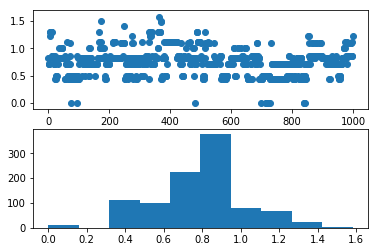

In [5]:
# Look at the arousal variables: arousal and standard deviation
arousalstds = np.std(file[arousalcols], axis = 1)
plt.figure(1)
plt.subplot(211)
plt.scatter(range(len(file)), np.std(file[arousalcols], axis = 1))
plt.subplot(212)
plt.hist(arousalstds)
# segments where the testers all agreed on the arousal vs. not
pctile1 = np.percentile(np.std(file[arousalcols], axis = 1), 1)
pctile99 = np.percentile(np.std(file[arousalcols], axis = 1), 99)
arousalsim = np.where(np.std(file[arousalcols], axis = 1) <= pctile1 )[0]
arousaldif = np.where(np.std(file[arousalcols], axis = 1) >= pctile99)[0]
display(arousalsim)
display(arousaldif)
arousalmeans = np.mean(file[arousalcols], axis = 1)

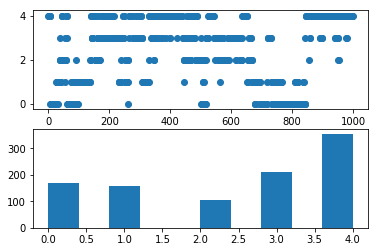

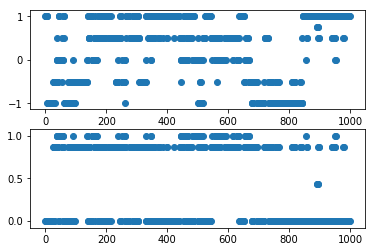

In [6]:
pos = file[valencecols] == '+'
totpos = [sum(pos.loc[i,:]) for i in range(len(pos))]
plt.figure(2)
plt.subplot(211)
plt.scatter(range(len(file)), totpos)
plt.subplot(212)
plt.hist(totpos)

valence_numeric = 1 * (file[valencecols] == '+') + -1 * (file[valencecols] == '-')
valencemeans = np.mean(valence_numeric, axis = 1)
valencestds = np.std(valence_numeric, axis = 1)
plt.figure(3)
plt.subplot(211)
plt.scatter(range(len(file)), valencemeans)
plt.subplot(212)
plt.scatter(range(len(file)), valencestds)

In [7]:
display(sum(np.asarray(totpos) == 2)) # 104 scene segments were highly variable
display(sum(valencestds == 0))
display(sum(valencestds == 1))

107

526

107

In [8]:
scenesegs = file.loc[:, 'Scene Segments']
newscene = [1 * (sceneseg.strip() != "") for sceneseg in scenesegs]
sum(newscene)

50

In [9]:
descripts = file.iloc[:, 6:-8]
descripts

,Scene Details - A Level,Space-In/Outdoor,Name - All,Name - Focus,Name - Speaking,Location,Camera Angle,Music Presence,Words on Screen
0,"People in popcorn, candy, and soft drink costu...",Indoor,Cartoon People in Costumes,Cartoon People in Costumes,Cartoon People in Costumes,Cartoon World,Long,Yes,
1,Popcorn is being popped in a large popcorn mac...,Indoor,Female Singer,,Female Singer,Cartoon World,Medium,Yes,
2,"Men sing in reply: ""the popcorn can't be beat!""",Indoor,Male Singers,,Male Singers,Cartoon World,Medium,Yes,
3,"A family of four, a father with a black suit, ...",Indoor,Background Singers,,Background Singers,Cartoon World,Medium,Yes,
4,A view of the lobby with a display of snacks f...,Indoor,"Cartoon Woman, Background Singers",Cartoon Woman,Background Singers,Cartoon World,Medium,Yes,
5,Let's all go to the Lobby to get Ourselves a T...,Indoor,Background Singers,,Background Singers,Cartoon World,Medium,Yes,Let's all go to the Lobby to get Ourselves a T...
6,There is an on-screen countdown from 3…2…1… as...,Indoor,Background Singers,,Background Singers,Cartoon World,,Yes,
7,Gunfire by a soldier along a wall made of stac...,Outdoor,Soldiers,Soldiers,,Afghanistan,Medium,No,
8,A bomb or land mine goes off in the middle of ...,Outdoor,Soldiers,Soldiers,,Afghanistan,Long,No,
9,A Soldier kicks open a door. Soldiers shooting...,Outdoor,Soldiers,Soldiers,,Afghanistan,Medium,No,


1000

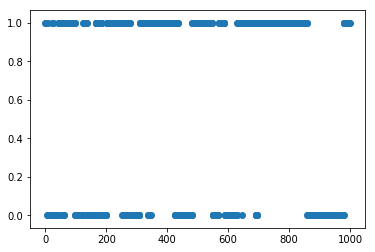

In [10]:
musicpresence = np.asarray(descripts.loc[:, 'Music Presence ']) 
bgmusic = [int(x == 'Yes') for x in musicpresence]
plt.scatter(range(len(file)), bgmusic)
sum(bgmusic) + sum(musicpresence == "No")

In [11]:
wordsonscreen_text = descripts.loc[:, 'Words on Screen ']
wordsonscreen = [1 * (words.strip() != "") for words in wordsonscreen_text]
[i for i in range(len(wordsonscreen)) if wordsonscreen[i] == 1]
wordsonscreen_text[[i for i in range(len(wordsonscreen)) if wordsonscreen[i] == 1]]


5      Let's all go to the Lobby to get Ourselves a T...
45                                              SHERLOCK
48                                    Bomber, Connection
55                                          October 12th
72                                        November 26th.
86     January 27th. Your local MP, Beth Davenport, J...
96                                      A STUDY IN PINK 
110                                               Wrong!
120                                               Wrong!
132                                               Wrong!
133                        You know where to find me. SH
254                                 Messages - Received 
255    Messages - Sent. If brother has green ladder a...
487    Let's all go to the Lobby to get Ourselves a T...
517                                          left handed
519                            RACHE German (n.) revenge
521                                               Rachel
522                            

In [12]:
indoors = 1 * (descripts.loc[:, 'Space-In/Outdoor'] == "Indoor")
outdoors = 1 * (descripts.loc[:, 'Space-In/Outdoor'] == "Outdoor")
sum((indoors + outdoors) == 0) # some scenes are neither indoors nor outdoors
[descripts.loc[:, 'Space-In/Outdoor'][i] for i in range(len(indoors))
                             if indoors[i] == 0 and outdoors[i] == 0]

['Various',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown']

In [13]:
namespeak = descripts.loc[:, 'Name - Speaking']
namefocus = descripts.loc[:, 'Name - Focus']
nameall = descripts.loc[:, 'Name - All']

speech = [1 * (txt.strip() != "") for txt in namespeak]
charinfocus = [1 * (txt.strip() != "") for txt in namefocus]
charinscene = [1 * (txt.strip() != "Nobody") for txt in nameall]

In [14]:
sum(speech), sum(charinfocus), sum(charinscene)

(698, 949, 968)

In [15]:
allchars = [name.strip() for name in nameall]
mychars = []
for chars in allchars:
    for char in chars.split(","):
        mychars.append(char.strip())
set(mychars)
mychardict = {}
for char in set(mychars):
    mychardict[char] = sum([char in allchars[i] for i in range(len(allchars))])
mychardict
#np.std(list(mychardict.values())) > 100
#np.mean(list(mychardict.values())) # 36.04
sorted_chars = sorted(mychardict, key = mychardict.get, reverse = True)
sorted_chars
# hard to determine who the major characters are, other than John and Sherlock
# as some recurring characters are statistically insignificant (or at least
# more so than arguably less important characters)

['John',
 'Sherlock',
 'Lestrade',
 'The Man',
 'Donovan',
 'Mike',
 'Nobody',
 'Jennifer Wilson',
 'Mrs. Hudson',
 'Anthea',
 'Anderson',
 'Policeman',
 'Molly',
 'Jimmy',
 'Sir Jeffrey',
 'Background Singers',
 'Soldiers',
 'Reporters',
 'Gary',
 'Woman Aide',
 'Helen',
 'Psychotherapist',
 'Man Aide',
 'People on the street',
 'Margaret Patterson',
 'Beth Davenport',
 'Reporter 1',
 'Policemen',
 'Cameramen',
 '2 Policemen',
 'People in Coveralls',
 'Reporter 3',
 'Female Singer',
 'Male Singers',
 'Reporter 2',
 'Cartoon Woman',
 'Cartoon People in Costumes',
 'Office Workers',
 'Driver',
 '2 People in Coveralls',
 'Person in Coveralls',
 'Man in a suit',
 'Chicken Cottage Serving Staff',
 'Unknown Soldier',
 'Policewoman',
 'Lawyer']

In [16]:
def majorcharpresent(chars):
    return 1 * (("Sherlock" in chars) or ("John" in chars))
majorcharinscene = [majorcharpresent(txt) for txt in nameall]
majorcharinfocus = [majorcharpresent(txt) for txt in namefocus]
majorcharspeaking = [majorcharpresent(txt) for txt in namespeak]

In [20]:
#'Start Time (TRs, 1.5s)', 'End Time (TRs, 1.5s)',
startTR = file['Start Time (TRs, 1.5s)']
endTR = file['End Time (TRs, 1.5s)']

In [21]:
features = {'start_TR': startTR,
            'end_TR': endTR,
            'arousal_mean': arousalmeans,
           'arousal_std': arousalstds,
           'valence_mean': valencemeans,
           'valence_std': valencestds,
           'text': wordsonscreen,
           'speech': speech,
           'music': bgmusic,
           'outdoors': outdoors,
           'new_scene': newscene,
           'char_infocus': charinfocus,
           'char_present': charinscene,
           'mainchar_infocus': majorcharinfocus,
           'mainchar_present': majorcharinscene,
           'mainchar_speaking': majorcharspeaking}
features = pd.DataFrame(features)
features.to_csv("features.csv")

In [295]:
movieTRs = pd.read_csv("SherlockData/moviesceneTRs.txt")
movieTRs = movieTRs.drop([0, 28, 29])

scenes = []
onsets = []
offsets = []
for row in range(len(movieTRs)):
    dat = [int(num) for num in movieTRs.iloc[row][0].strip().split(" ") if num != ""]
    if row >= 27: # second scan 
        scenes.append(27 + dat[0])
        onsets.append(946 + dat[1])
        offsets.append(946 + dat[2])
    else:
        scenes.append(dat[0])
        onsets.append(dat[1])
        offsets.append(dat[2])
        
movieTRdf = pd.DataFrame({
    'Scene': scenes,
    'Onset': onsets,
    'Offset': offsets
})

movieTRdf.to_csv("movieTRs.csv")

In [338]:
recallTRs = pd.read_csv("SherlockData/recallsceneTRs.txt")
recallTRs = [row for row in recallTRs['Subject 1:'] if "Scene" not in row]
sbjrows = [row for row in range(len(recallTRs)) if "Subject" in recallTRs[row]]
sbjrows = [row + 1 for row in sbjrows]
sbjrows = [0] + sbjrows + [len(recallTRs) + 1]

recallTRdict = {}
for sbj in range(1, len(sbjrows)):
    scenes = []
    onsets = []
    offsets = []
    for row in range(sbjrows[sbj - 1], sbjrows[sbj] - 1):
        dat = [int(num) for num in recallTRs[row].strip().split(" ") if num != ""]
        scenes.append(dat[0])
        onsets.append(dat[1])
        offsets.append(dat[2])

    recallTRdf = pd.DataFrame({
        'Scene': scenes,
        'Onset': onsets,
        'Offset': offsets
    })
    recallTRdf.to_csv("recallTRs/recallTRs_S" + str(sbj) + ".csv")
    recallTRdict[sbj] = recallTRdf
    
recallTRdict[17]

,Scene,Onset,Offset
0,2,41,51
1,3,52,67
2,4,69,81
3,5,83,109
4,7,112,136
5,8,138,146
6,8,384,387
7,9,147,163
8,10,165,185
9,11,186,197


In [2]:
# transform .nii to .npz files, masked
import nibabel as nib

#NOTE: Data is already preprocessed and transformed into 3mm MNI space:
# z-scored at every voxel, 6mm smoothing, correction for hemodynamic lag;
# movie-viewing data are aligned across subjects,
# recall data are aligned to scene timestamps (see above)
# (concatenated) two scan sessions of 946 + 1030 = 1976 TRs total length
# note: Subject 5 has some missing data at the end

# we want to create imaging data arrays such that 
# each element is a single participants' voxel x TR data 
# reading recall data

recalldat = {}
recalldat_path = "SherlockData/recall_files/"
for pid in range(9, 18):
    filename = "sherlock_recall_s" + str(pid) + ".nii"
    recalldat[pid] = nib.load(recalldat_path + filename)
    
# reading movie data
moviedat = {}
moviedat_path = "SherlockData/movie_files/"
for pid in range(9, 18):
    filename = "sherlock_movie_s" + str(pid) + ".nii"
    moviedat[pid] = nib.load(moviedat_path + filename)

# load in whole brain mask 
# the "Whole Brain" ROI is a 26000 voxel mask of the brain that highlights
# voxels that have an intersubject correlation > 0.2
wbmask = np.load("SherlockData/WB_mask.nii.npz")['mask']
# print([key for key in wbmask.keys()]) # mask
np.shape(wbmask) # 271,633 sized np-array

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(271633,)

In [3]:

start = time.time()
for pid in range(9, 18):
    moviedat_np = []
    recalldat_np = []
    moviedat_bs = moviedat[pid].get_data()
    recalldat_bs = recalldat[pid].get_data()
    
    x, y, z, T = np.shape(moviedat_bs)
    for t in range(T):
        datslice = np.reshape(moviedat_bs[:, :, :, t], x * y * z)
        moviedat_np.append(datslice[np.nonzero(wbmask)[0]])
    
    x, y, z, T = np.shape(recalldat_bs)
    for t in range(T):
        datslice = np.reshape(recalldat_bs[:, :, :, t], x * y * z)
        recalldat_np.append(datslice[np.nonzero(wbmask)[0]])
    
    np.savez("SherlockData/movie_masked/movie_wb_S" + str(pid) + ".npz", 
            data = moviedat_np)
    np.savez("SherlockData/recall_masked/recall_wb_S" + str(pid) + ".npz", 
            data = recalldat_np)
    print("Participant done: " + str(pid))
    print("Current time elapsed: " + str(time.time() - start))


end = time.time()
print(end - start)

Participant done: 9
Current time elapsed: 12.462765216827393
Participant done: 10
Current time elapsed: 25.385926008224487
Participant done: 11
Current time elapsed: 36.895761013031006
Participant done: 12
Current time elapsed: 52.970690965652466
Participant done: 13
Current time elapsed: 74.99517130851746
Participant done: 14
Current time elapsed: 90.93486285209656
Participant done: 15
Current time elapsed: 104.5290515422821
Participant done: 16
Current time elapsed: 118.9409613609314
Participant done: 17
Current time elapsed: 135.8409767150879
135.84128499031067
